# Towards Data Science Blog Posts: Topic Modeling with Latent Dirichlet Allocation & MALLET
## Trigram Models 
### *Create and select a topic model, then classify each document according to the dominant topic. Once classified, explore the relationship between topics and the target variable, claps* 
Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [3]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [4]:
filename = '../data/cleaned_no_outliers.csv'

In [5]:
#read in the data
df = pd.read_csv(filename)

In [6]:
df.columns

Index(['date', 'title', 'subtitle', 'claps', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 'section_titles',
       'number_paragraphs', 'paragraphs'],
      dtype='object')

In [7]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Combine Title & Subtitle

In [8]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [9]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [10]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [11]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [12]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [13]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [14]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [15]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [16]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [20]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [21]:
#!spacy download en_core_web_lg

In [22]:
nlp = spacy.load('en_core_web_lg')

In [23]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [24]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [25]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [26]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Trigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [28]:
#check out the dictionary

id2word[0]

'abbreviate'

### Build LDA Mallet Model

In [29]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [30]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [31]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.46238442691039977


In [32]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [33]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.079998 -0.179287       1        1  10.756453
1      0.182331 -0.031190       2        1   9.777249
2      0.141700  0.073153       3        1   9.572095
3     -0.225124  0.069032       4        1  10.557084
4     -0.021825  0.233973       5        1   8.977875
5      0.199570  0.074679       6        1  12.139501
6     -0.115197 -0.288933       7        1  10.379350
7     -0.162933  0.071418       8        1  10.475029
8     -0.162591  0.017513       9        1   9.901734
9      0.084071 -0.040358      10        1   7.463631, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126655.000000  126655.000000  Default  30.0000  30.0000
239      model   66421.000000   66421.000000  Default  29.0000  29.0000
939      image   19540.000000   19540.000000  Default  28.0000  28.0000
320    science   17518.000000   17518.000000  Default  27.0000  27.0000
932   function   27894.000000   27894.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
136       find    2317.159326   20241.559257  Topic10  -5.1206   0.4277
759     result    2129.281562   18221.766752  Topic10  -5.2052   0.4483
1010      step    1907.771351   14987.856380  Topic10  -5.3150   0.5338
149       give    1883.416732   16089.249967  Topic10  -5.3278   0.4501
142     follow    1820.790931   19780.922982  Topic10  -5.3617   0.2097

[986 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
421      10  0.970045          abcd
1351      2  1.012292  abstract_art
7083      4  1.001080      academia
1566      1  0.145432        access
1566      4  0.004571        access
...     ...       ...           ...
2731      8  1.106972       wyscout
418       1  0.030489          year
418       4  0.324954          year
418       5  0.547765          year
418       8  0.096740          year

[1945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The coherence score is acceptable, but there is a lot of topic overlap, and few topics in the lower right quadrant. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using 
1) coherence score 
2) qualitative evaluation of topic spread/overlap 

as my evaluation metrics.

#### Compute Optimal Number of Topics Based on Coherence

In [34]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        #store the topic model
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_trig.pkl')

    return model_list, coherence_values, num_topics_list

In [35]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_trigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [36]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_trig.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_trig.pkl')

['stored_models/optimal_ldamallet_model_trig.pkl']

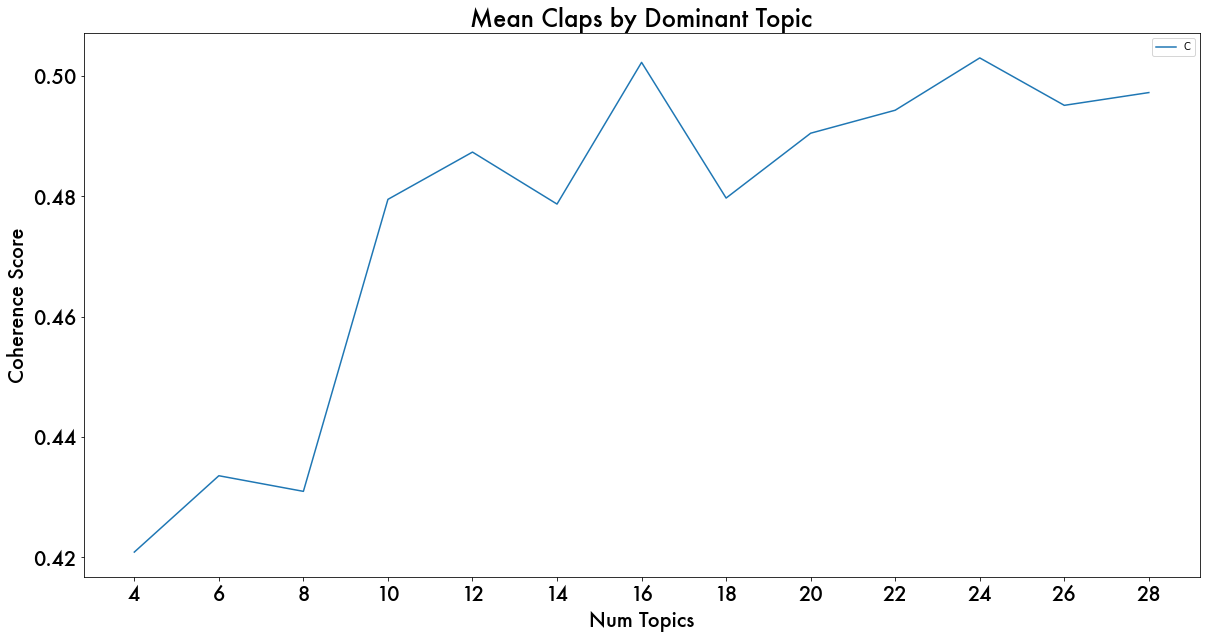

In [37]:
# Show coherence values graph

limit=30; start=4; step=2;
x = range(start, limit, step)
plt.figure(figsize = (20, 10));
sns.lineplot(x=x, y=coherence_values);
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(ticks=range(4,30,2), **figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Num Topics',**figurefont, fontsize = 20);
plt.ylabel('Coherence Score',**figurefont, fontsize = 20);
plt.legend('Coherence Values', loc='best')

plt.savefig('../figures/tds_coherence_trigrams.jpg',  bbox_inches = "tight")

The coherence is highest at 16 topics, followed by 12 and 10.

### Create & Visualize Model with Optimal Number of Topics

In [41]:
optimal_model = joblib.load('stored_models/ldamallet_model16_trig.pkl')

#### LDA Mallet Model: 16 Topics

In [42]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.502203941553386


In [45]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model16_trig.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.113116 -0.118080       1        1  8.179714
1     -0.044977  0.185845       2        1  6.459997
2     -0.104724 -0.017432       3        1  4.691949
3      0.102101  0.285276       4        1  7.167348
4     -0.141337  0.127436       5        1  7.902423
5      0.197614  0.120484       6        1  6.372091
6      0.099716 -0.014210       7        1  5.248619
7     -0.220776 -0.021149       8        1  6.373555
8     -0.100757 -0.083833       9        1  4.601930
9      0.148048 -0.056107      10        1  6.209620
10    -0.233902  0.076414      11        1  7.822386
11     0.142749  0.060065      12        1  6.494662
12     0.120341 -0.116080      13        1  6.423104
13    -0.049258 -0.129430      14        1  4.764559
14    -0.074863 -0.102657      15        1  4.900090
15     0.046908 -0.196542      16        1  6.387953, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126315.000000  126315.000000  Default  30.0000  30.0000
239      model   65807.000000   65807.000000  Default  29.0000  29.0000
939      image   19418.000000   19418.000000  Default  28.0000  28.0000
932   function   28052.000000   28052.000000  Default  27.0000  27.0000
414       word   12038.000000   12038.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
142     follow    2309.346485   19798.514251  Topic16  -4.9683   0.6021
957     method    2034.287771   15013.974629  Topic16  -5.0952   0.7519
80        data    2831.957731  126315.576741  Topic16  -4.7643  -1.0471
1600     event    1495.631252    3333.928806  Topic16  -5.4028   1.9492
16    analysis    1497.923434   10474.382723  Topic16  -5.4012   0.8059

[1553 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
421        9  0.953525             abcd
18698      9  0.998931           accent
1566       2  0.295927           access
1566       3  0.025353           access
1566       4  0.336243           access
...      ...       ...              ...
3221       2  0.894234            yetgo
4783       6  0.876633   yjrequirements
13426     10  0.999990             yolo
1349       1  1.074045           youden
12636      5  0.997673  youtube_channel

[3461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

Decent distribution across the space; but a bit of overlap. I will explore the other peaks to see if there is a better spread.

#### LDA Mallet Model: 12 Topics

In [46]:
ldamallet_model = joblib.load('stored_models/ldamallet_model12_trig.pkl')

In [47]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4873052939393421


In [49]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model12_trig.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.027645  0.243817       1        1   8.399167
1      0.169407  0.005092       2        1   9.533396
2     -0.163887  0.017168       3        1   8.130417
3      0.064302 -0.005270       4        1   6.543731
4      0.016747 -0.078314       5        1   7.413685
5      0.022450 -0.248436       6        1   8.138477
6      0.176109  0.016164       7        1   7.669907
7     -0.189356 -0.236821       8        1   8.731726
8     -0.198182  0.157453       9        1  10.417704
9      0.138067 -0.032941      10        1   8.029192
10    -0.160598  0.066257      11        1   9.351467
11     0.152586  0.095830      12        1   7.641130, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126674.000000  126674.000000  Default  30.0000  30.0000
239      model   66308.000000   66308.000000  Default  29.0000  29.0000
932   function   28151.000000   28151.000000  Default  28.0000  28.0000
939      image   19533.000000   19533.000000  Default  27.0000  27.0000
320    science   17279.000000   17279.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
1130    assume    1511.608031    3088.766997  Topic12  -5.5713   1.8570
142     follow    2295.747523   19864.026300  Topic12  -5.1534   0.4138
890       case    2152.335623   15583.277881  Topic12  -5.2179   0.5920
2365      team    1688.559880    7462.279188  Topic12  -5.4606   1.0856
163       high    1682.777082    9651.007791  Topic12  -5.4640   0.8250

[1167 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
421       11  0.978188               abcd
1946       9  0.087851         absolutely
1946      11  0.912673         absolutely
4217       4  0.028026           academic
4217       9  0.972143           academic
...      ...       ...                ...
418       11  0.142406               year
419        4  0.013585      youtube_video
419       11  0.984924      youtube_video
11192      4  0.998650           zeroshot
14097      4  0.962554  zeroshot_transfer

[2405 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#### LDA Mallet Model: 10 Topics

In [50]:
ldamallet_model = joblib.load('stored_models/ldamallet_model10_trig.pkl')

In [52]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4794549118090129


In [53]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model10_trig.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.161354  0.255431       1        1  10.802045
1      0.061711  0.043995       2        1   7.648246
2     -0.201492 -0.107268       3        1  11.298666
3     -0.041283 -0.150745       4        1   8.192914
4     -0.191260 -0.066187       5        1  12.367061
5      0.180763 -0.022281       6        1  10.753225
6      0.017964  0.192952       7        1  10.509164
7      0.163630  0.070768       8        1   9.463255
8      0.149110 -0.064635       9        1  10.510785
9      0.022212 -0.152028      10        1   8.454639, topic_info=         Term           Freq          Total Category  logprob  loglift
239     model   66630.000000   66630.000000  Default  30.0000  30.0000
80       data  126865.000000  126865.000000  Default  29.0000  29.0000
939     image   19570.000000   19570.000000  Default  28.0000  28.0000
932  function   27983.000000   27983.000000  Default  27.0000  27.0000
320   science   17439.000000   17439.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
250    number    2386.425043   19639.035534  Topic10  -5.2158   0.3627
976    people    1843.061634    8102.868284  Topic10  -5.4742   0.9897
904    create    2324.260622   24712.302969  Topic10  -5.2422   0.1066
136      find    2013.438310   20198.796404  Topic10  -5.3858   0.1647
661      make    1669.231243   13559.638242  Topic10  -5.5732   0.3757

[971 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
421       2  0.971280      abcd
7083      5  1.001309  academia
1566      1  0.520127    access
1566      3  0.295787    access
1566      7  0.184138    access
...     ...       ...       ...
418       4  0.315982      year
418       5  0.331999      year
418       8  0.000384      year
418      10  0.237435      year
2327      4  1.001414    yearly

[1892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

This model provides the best balance of spread, disambiguation, and coherence score. Ultimately I will go with the 10-Topic bigram version of the model in the other notebook as the final model, because the coherence score is slightly higher, and the keywords make a bit more sense. 

### Find the Dominant Topic in Each Document

In [54]:
pd.set_option('max_colwidth', 100)

In [55]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_trigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [56]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_trigrams)

df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to match df
df_dominant_topic.index = df.index


In [57]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6269,"data, science, learn, work, scientist, project, good, time, start, question","[ultimate_guide, ace, code, interview, data, scientist, data, science, ultimate_guide, ace, code..."
1,1,1.0,0.4284,"word, text, model, language, document, topic, sentence, article, vector, task","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,7.0,0.4388,"image, model, training, input, layer, network, output, learn, train, neural_network","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision_transformer_vit,..."
3,3,6.0,0.3359,"data, function, python, column, code, table, list, create, method, type","[stock_price, analysis, panda, altair, practical_guide, panda, altairstock, price, analysis, pan..."
4,4,5.0,0.6012,"model, data, feature, dataset, prediction, predict, set, algorithm, test, training","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


#### Find the most representative document for each topic

In [58]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to match df numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [59]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
1218,0.0,0.8216,"create, file, run, code, python, follow, project, api, build, package","[publish, python, package, pypi, publish, python, packageshow, publish, python, package, pypi, p..."
5401,1.0,0.7157,"word, text, model, language, document, topic, sentence, article, vector, task","[important, word, text, data, tfidf, answer, article, explain, bag, important, word, text, data,..."
8446,2.0,0.7846,"data, system, ai, team, business, process, company, solution, tool, design","[data, catalog, dead, long, live, data, discovery, opiniondata, catalog, dead, long, live, data,..."
7643,3.0,0.8238,"data, time, cluster, customer, analysis, day, group, series, number, product","[understand, forecasting, customer_lifetime_value, cltv, understanding, forecasting, customer_li..."
2534,4.0,0.8294,"data, science, learn, work, scientist, project, good, time, start, question","[need, master_degree, become, data, scientist, experience, realization, need, master_degree, bec..."
8515,5.0,0.7746,"model, data, feature, dataset, prediction, predict, set, algorithm, test, training","[mustknow, classification, metric, machine_learning, evaluate, classification, model, mustknow, ..."
8693,6.0,0.8714,"data, function, python, column, code, table, list, create, method, type","[useful, thing, know, python, extremely, useful, function, expression, know, python, useful, thi..."
7773,7.0,0.8257,"image, model, training, input, layer, network, output, learn, train, neural_network","[paper, read, deep, image, inpainte, paper, read, deep, image, inpainte, image, inpainte, termin..."
657,8.0,0.8547,"probability, distribution, state, function, number, variable, sample, give, algorithm, problem","[comprehensive_overview, random, variable, random, process, property, part, comprehensive_overvi..."
740,9.0,0.7686,"data, plot, graph, visualization, show, analysis, chart, game, map, player","[espresso, puck, analysis, coffee, data, scienceespresso, puck, analysis, first, example, top, f..."


#### Explore Relationship Between Dominant Topic and Number of Claps

In [60]:
df.head()

,claps,text
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...


In [61]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6269,"data, science, learn, work, scientist, project, good, time, start, question","[ultimate_guide, ace, code, interview, data, scientist, data, science, ultimate_guide, ace, code..."
1,1,1.0,0.4284,"word, text, model, language, document, topic, sentence, article, vector, task","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,7.0,0.4388,"image, model, training, input, layer, network, output, learn, train, neural_network","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision_transformer_vit,..."
3,3,6.0,0.3359,"data, function, python, column, code, table, list, create, method, type","[stock_price, analysis, panda, altair, practical_guide, panda, altairstock, price, analysis, pan..."
4,4,5.0,0.6012,"model, data, feature, dataset, prediction, predict, set, algorithm, test, training","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


In [62]:
#merge on index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [63]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [64]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [65]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,4.0,0.6269,"data, science, learn, work, scientist, project, good, time, start, question"
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,1.0,0.4284,"word, text, model, language, document, topic, sentence, article, vector, task"
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,7.0,0.4388,"image, model, training, input, layer, network, output, learn, train, neural_network"
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,6.0,0.3359,"data, function, python, column, code, table, list, create, method, type"
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,5.0,0.6012,"model, data, feature, dataset, prediction, predict, set, algorithm, test, training"


In [66]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [67]:
#colum order
new_column_order = combined_df.groupby('Dominant_Topic')['claps'].mean().sort_values().index

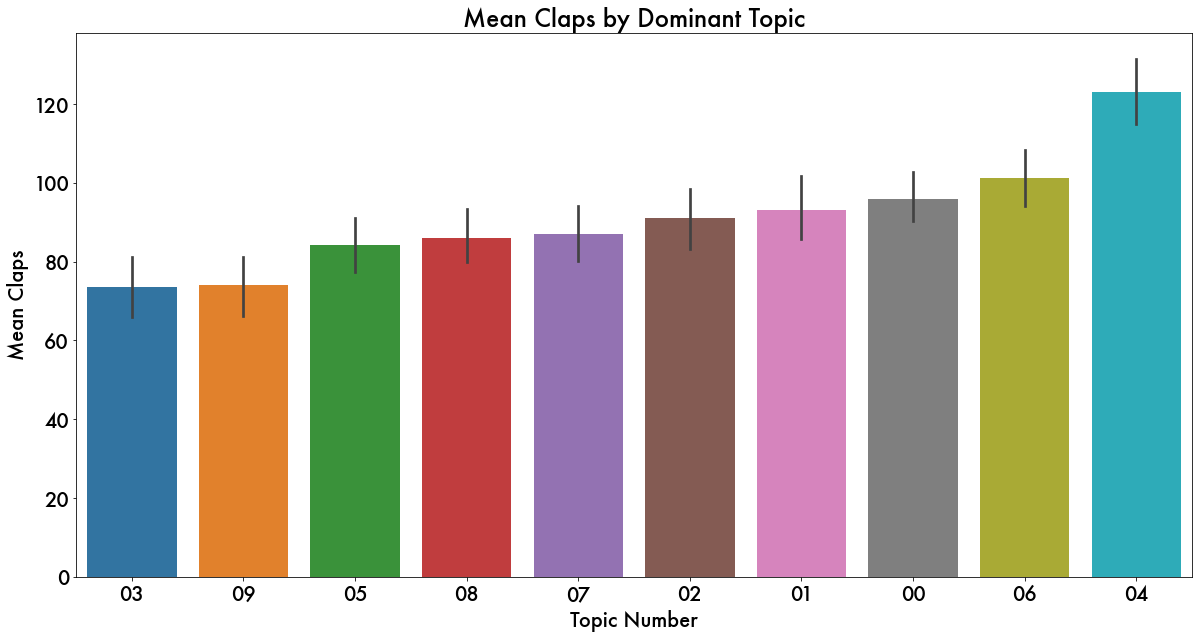

In [68]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='claps', order= new_column_order);
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_trigram_model12.jpg',  bbox_inches = "tight")

In [69]:
combined_df['Dominant_Topic'].value_counts()

00    1234
04    1152
06    1070
05     946
07     945
02     888
08     885
09     812
01     759
03     599
Name: Dominant_Topic, dtype: int64

#### Model Claps by Topic

In [70]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [71]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09'],
      dtype='object')

In [72]:
import statsmodels.api as sm

In [73]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,0.6269,"data, science, learn, work, scientist, project, good, time, start, question",0,0,0,1,0,0,0,0,0
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,0.4284,"word, text, model, language, document, topic, sentence, article, vector, task",1,0,0,0,0,0,0,0,0
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,0.4388,"image, model, training, input, layer, network, output, learn, train, neural_network",0,0,0,0,0,0,1,0,0
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.3359,"data, function, python, column, code, table, list, create, method, type",0,0,0,0,0,1,0,0,0
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,0.6012,"model, data, feature, dataset, prediction, predict, set, algorithm, test, training",0,0,0,0,1,0,0,0,0


In [74]:
X = model_df.drop(columns=['text','claps','Keywords', 'Topic_Perc_Contrib'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [75]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     15.02
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.55e-24
Time:                        18:22:51   Log-Likelihood:                -57282.
No. Observations:                9290   AIC:                         1.146e+05
Df Residuals:                    9280   BIC:                         1.147e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                96.0251      3.282     29.255      0.000      89.591     102.459
Dominant_Topic_01    -2.8433      5.319     -0.535      0.593     -13.269       7.583
Dominant_Topic_02    -4.9553      5.074     -0.977      0.329     -14.902       4.991
Dominant_Topic_03   -22.4909      5.742     -3.917      0.000     -33.746     -11.236
Dominant_Topic_04    27.0330      4.724      5.723      0.000      17.773      36.293
Dominant_Topic_05   -11.6921      4.983     -2.347      0.019     -21.459      -1.925
Dominant_Topic_06     5.2095      4.817      1.082      0.279      -4.232      14.651
Dominant_Topic_07    -9.0325      4.984     -1.812      0.070     -18.803       0.738
Dominant_Topic_08   -10.0409      5.079     -1.977      0.048     -19.997      -0.085
Dominant_Topic_09   -22.0645      5.210     -4.235      0.000     -32.278     -11.851
==============================================================================
Omnibus:                     4609.930   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26550.942
Skew:                           2.390   Prob(JB):                         0.00
Kurtosis:                       9.764   Cond. No.                         9.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As one might expect, there is quite a bit more going on here beyond just the dominant topic in an abstract; these topics account for very little of the variance in claps.